In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [73]:
imu_data = pd.read_csv("data/michelin_enduro.csv", dtype=np.float64) 
# gps speed is in m/s, acc in G

In [74]:
gps_data = imu_data[['Time','Acceleration X', 'GPS Latitude', 'GPS Longitude']]
gps_data = gps_data[46274:46774]

In [75]:
math_channels = pd.read_csv("data/michelin_math.csv", dtype=np.float64)

In [76]:
class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0

    def predict(self, u = 0):
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x

    def update(self, z):
        y = z - np.dot(self.H, self.x)
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.n)
        self.P = np.dot(np.dot(I - np.dot(K, self.H), self.P), 
        	(I - np.dot(K, self.H)).T) + np.dot(np.dot(K, self.R), K.T)

In [102]:
def test(acc):
	dt = 0.001
	F = np.array([[1, dt, 0], [0, 1, dt], [0, 0, 1]])
	H = np.array([1, 0, 0]).reshape(1, 3)
	Q = np.array([[0.05, 0.05, 0.0], [0.05, 0.05, 0.0], [0.0, 0.0, 0.0]])
	R = np.array([0.5]).reshape(1, 1)


	kf = KalmanFilter(F = F, H = H, Q = Q, R = R)
	predictions = []

	for z in acc:
		predictions.append(np.dot(H,  kf.predict())[0])
		kf.update(z)


	plt.plot(range(len(acc)), acc,  label = 'Measurements')
	plt.plot(range(len(math_channels)), np.array(math_channels['x_cheb_bp']), label = 'chebyshev')
	plt.plot(range(len(math_channels)), np.array(math_channels['xaccel_filter']), label = 'Bandpass')
	plt.plot(range(len(predictions)), np.array(predictions),  label = 'Kalman Filter Prediction')

	plt.legend()
	plt.show()

	preds = pd.DataFrame(predictions)
	return preds

In [103]:
acc_x = gps_data['Acceleration X']
bandpass = math_channels['xaccel_filter']
cheb = math_channels['x_cheb_bp']

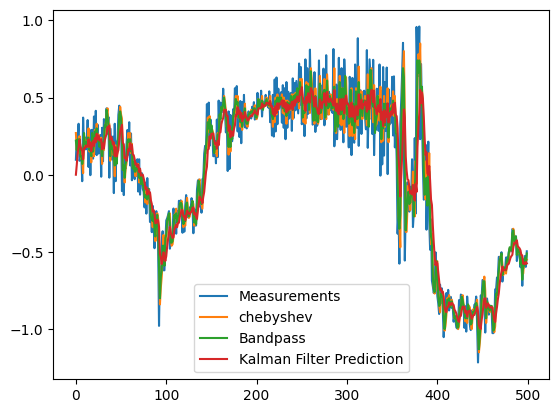

In [104]:
preds= test(acc_x)

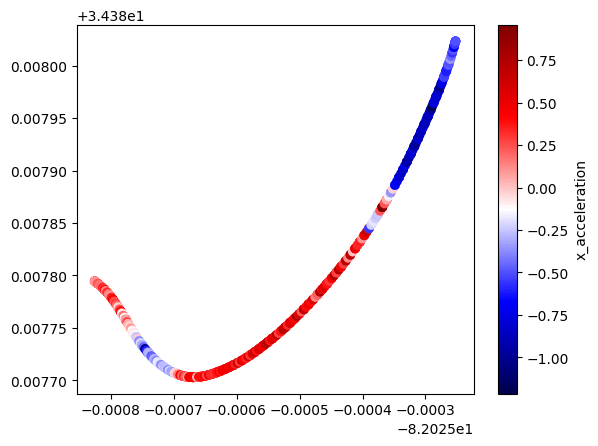

In [98]:
plt.scatter(x=gps_data['GPS Longitude'], y=gps_data['GPS Latitude'], c = acc_x, cmap = 'seismic')
plt.colorbar(label='x_acceleration')
plt.show()

# take motec math channel and compare, time is 512-517 s

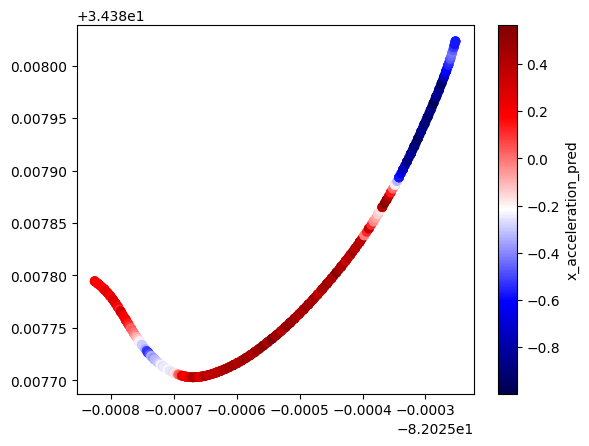

In [99]:
plt.scatter(x=gps_data['GPS Longitude'], y=gps_data['GPS Latitude'], c = preds, cmap = 'seismic')
plt.colorbar(label='x_acceleration_pred')

plt.show()

#add gates to look at one lap/corner 

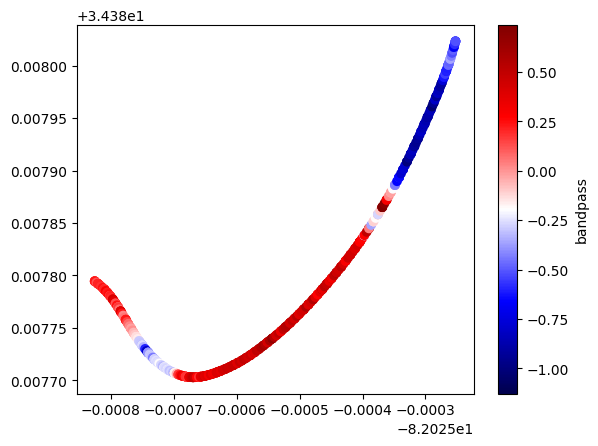

In [100]:
plt.scatter(x=gps_data['GPS Longitude'], y=gps_data['GPS Latitude'], c = bandpass, cmap = 'seismic')
plt.colorbar(label='bandpass')
plt.show()


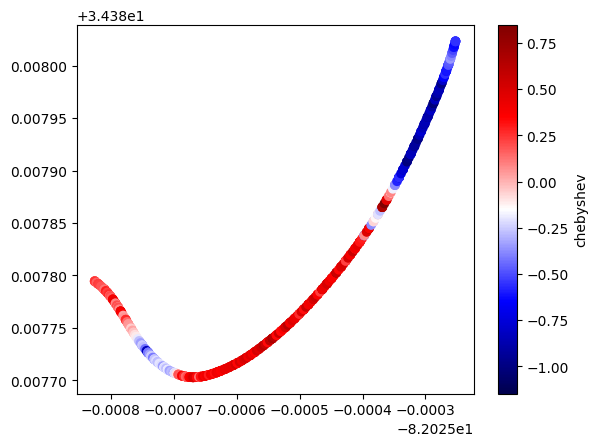

In [101]:
plt.scatter(x=gps_data['GPS Longitude'], y=gps_data['GPS Latitude'], c = cheb, cmap = 'seismic')
plt.colorbar(label='chebyshev')
plt.show()
